## Imports

In [139]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


## Importing Data

##### Custom Dataset Class

In [140]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, file, scaler):
    self.df = pd.read_csv(file)
    self.sc = scaler
    self.sc.fit(self.df)

  def __len__(self):
    return self.df.shape[0]
  
  def __getitem__(self, idx):
    raw = self.df.iloc[idx].values
    if type(idx) == int:
      raw = raw.reshape(1, -1)
    raw = self.sc.transform(raw)
    data = torch.tensor(raw[:, 1:], dtype=torch.float32) # Features
    label = torch.tensor(raw[:, 0], dtype=torch.float32) # Label
    return data, label

##### Importing Training Data and Scaling based on each

In [149]:
""" Center Surround Training Data """
center_surround_train_df = pd.read_csv("./center_surround_train.csv")
center_surround_scaler = MinMaxScaler().fit(center_surround_train_df)
center_surround_train_data = CustomDataset('./center_surround_train.csv', center_surround_scaler)
center_surround_test_data = CustomDataset('./center_surround_test.csv', center_surround_scaler)
center_surround_valid_data = CustomDataset('./center_surround_valid.csv', center_surround_scaler)

center_surround_train_loader = DataLoader(center_surround_train_data, batch_size=32, shuffle=True)
center_surround_test_loader = DataLoader(center_surround_test_data, batch_size=32, shuffle=True)

""" Spiral Test Training Data """
spiral_train_df = pd.read_csv("./spiral_train.csv")
spiral_scaler = MinMaxScaler().fit(spiral_train_df)
spiral_train_data = CustomDataset('./spiral_train.csv', spiral_scaler)
spiral_test_data = CustomDataset('./spiral_test.csv', spiral_scaler)
spiral_valid_data = CustomDataset('./spiral_valid.csv', spiral_scaler)

spiral_train_loader = DataLoader(spiral_train_data, batch_size=32, shuffle=True)
spiral_test_loader = DataLoader(spiral_test_data, batch_size=32, shuffle=True)

""" Two Gaussians Training Data """
two_gaussians_train_df = pd.read_csv("./two_gaussians_train.csv")
two_gaussians_scaler = MinMaxScaler().fit(two_gaussians_train_df)
two_gaussians_train_data = CustomDataset('./two_gaussians_train.csv', two_gaussians_scaler)
two_gaussians_test_data = CustomDataset('./two_gaussians_test.csv', two_gaussians_scaler)
two_gaussians_valid_data = CustomDataset('./two_gaussians_valid.csv', two_gaussians_scaler)

two_gaussians_train_loader = DataLoader(two_gaussians_train_data, batch_size=32, shuffle=True)
two_gaussians_test_loader = DataLoader(two_gaussians_test_data, batch_size=32, shuffle=True)


""" XORTraining Data """
xor_train_df = pd.read_csv("./xor_train.csv")
xor_scaler = MinMaxScaler().fit(xor_train_df)
xor_train_data = CustomDataset('./xor_train.csv', xor_scaler)
xor_test_data = CustomDataset('./xor_test.csv', xor_scaler)
xor_valid_data = CustomDataset('./xor_valid.csv', xor_scaler)

xor_train_loader = DataLoader(xor_train_data, batch_size=32, shuffle=True)
xor_test_loader = DataLoader(xor_test_data, batch_size=32, shuffle=True)



In [150]:
for X, y in center_surround_train_loader:
  for i in range(3):  
    print("Example #: ", i + 1)
    print("Features: ", X[i])
    print("Label: ", y[i])
  break  

Example #:  1
Features:  tensor([[0.5118, 0.4171]])
Label:  tensor([0.])
Example #:  2
Features:  tensor([[0.7326, 0.5709]])
Label:  tensor([1.])
Example #:  3
Features:  tensor([[0.4903, 0.4238]])
Label:  tensor([0.])


## Modeling

#### Feed Forward Neural Network

In [151]:
class SimpleFFNN(nn.Module):
  def __init__(self, size_in, size_out, hidden_n):
    super(SimpleFFNN, self).__init__()
    self.linear_1 = nn.Linear(size_in, hidden_n)
    self.linear_activation = nn.Tanh()
    self.output = nn.Linear(hidden_n, size_out)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.linear_activation(x)
    x = self.output(x)
    return x


#### Training the Model and Testing the model

In [152]:
def calculate_loss(dataloader, model, loss_func, optimizer, train=True):
  """
  Parameters
  ----------
  dataloader: The torch DataLoader() object with your data (either training or testing or valid)
  model: Neural network model
  loss_func: Loss Function
  optimizer: Optimizer
  train: Boolean that represents whether you are training. If not, it will treat it as testing

  About
  -----
  Rather than writing two separate functions for train() and test(), 
  each have very similar logic, so I combined it and just added a boolean,
  that determines when to treat it like training or not.
  """
  if train:
    model.train()
  else:
    model.eval()

  running_loss = 0.0
  loss_array = []
  for batch, (X, y) in enumerate(dataloader):
    if train:
      optimizer.zero_grad()

    y = y.squeeze().long()    
    logits = model(X.squeeze(1))  # Outputs: [32, 2], y: [32,]
  
    loss = loss_func(logits, y)

    if train:
      loss.backward()
      optimizer.step()

    running_loss += loss.item()
    if batch % 10 == 0:
      loss_array.append(running_loss)
  return loss_array

"""
def train(dataloader, model, loss_func, optimizer):
  model.train()
  running_loss = 0.0

  train_loss = []
  for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()

    y = y.squeeze().long()    
    logits = model(X.squeeze(1))  # Outputs: [32, 2], y: [32,]
  
    loss = loss_func(logits, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if batch % 10 == 0:
      train_loss.append(running_loss)
  return train_loss
"""
"""
def test(dataloader, model, loss_func):
  model.eval()
  running_loss = 0.0

  test_loss = []
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      logits = model(X.squeeze(1))
      y = y.squeeze().long()
      loss = loss_func(logits, y).item()
      running_loss += loss

      if batch % 10 == 0:
        test_loss.append(running_loss)
  return test_loss
"""

'\ndef test(dataloader, model, loss_func):\n  model.eval()\n  running_loss = 0.0\n\n  test_loss = []\n  with torch.no_grad():\n    for batch, (X, y) in enumerate(dataloader):\n      logits = model(X.squeeze(1))\n      y = y.squeeze().long()\n      loss = loss_func(logits, y).item()\n      running_loss += loss\n\n      if batch % 10 == 0:\n        test_loss.append(running_loss)\n  return test_loss\n'

### Looking at loss of each set over epochs

In [153]:
def train_and_test_wrapper(training_set, test_set, title=""):
  model = SimpleFFNN(2, 2, hidden_n=5)
  lr = 1e-3
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  epochs = 100

  epoch_list = [i for i in range(epochs)] # [0, 1, ... n epochs]
  train_loss = [] # [loss epoch 0, loss epoch 1, .... loss epoch n]
  test_loss = []  # [loss epoch 0, loss epoch 1, .... loss epoch n]
  for _ in range(epochs):
    train_loss.append(calculate_loss(training_set, model, loss_func, optimizer, train=True)[0]) # TRAINING LOSS
    test_loss.append(calculate_loss(test_set, model, loss_func, optimizer, train=False)[0]) # TESTING LOSS

  plt.plot(epoch_list, train_loss, label="Training Loss")
  plt.plot(epoch_list, test_loss, label="Testing Loss")
  plt.title(title)
  plt.legend()
  plt.show()

### Charts

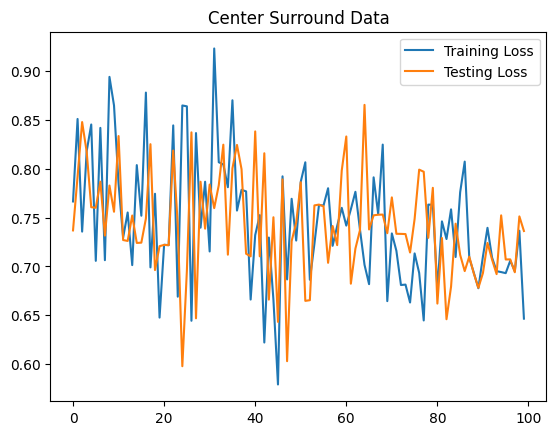

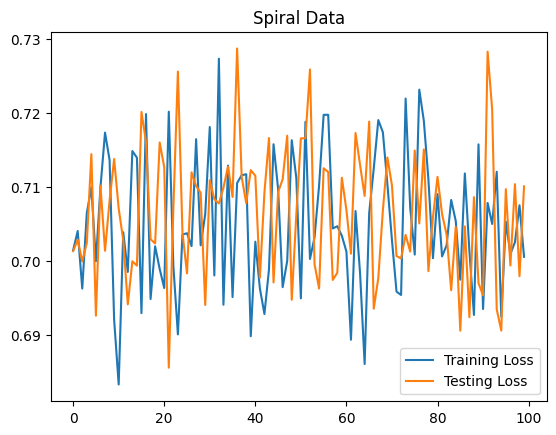

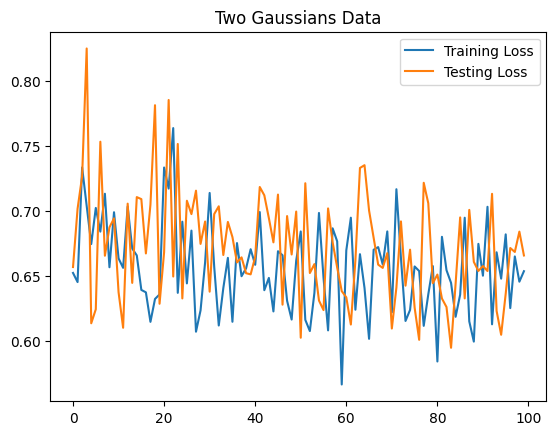

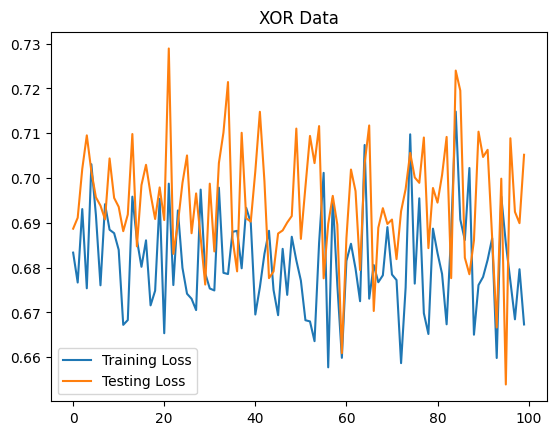

In [155]:
train_and_test_wrapper(center_surround_train_loader, center_surround_test_loader, title="Center Surround Data") 
train_and_test_wrapper(spiral_train_loader, spiral_test_loader, title="Spiral Data") 
train_and_test_wrapper(two_gaussians_train_loader, two_gaussians_test_loader, title="Two Gaussians Data") 
train_and_test_wrapper(xor_train_loader, xor_test_loader, title="XOR Data") 